In [18]:
import helpFunctions as hf 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import scipy as sp
import os

## Load Data

In [19]:
# Folder where your data files are placed
dirIn = "./data/"

matFile = os.path.join(dirIn, 'multispectral_day01.mat')
annFile = os.path.join(dirIn, 'annotation_day01.png')

# Load multispectral image and annotation using your original helpFunctions
multiIm, annotationIm = hf.loadMulti(matFile, annFile)

## The function getPix extracts the multi spectral pixels from the annotation
# Here is an example with meat- and fat annotation
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
[meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);

# load non-annotated pixels to be classified
[bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

## 1. Threshold value for a single spectral band (Model 1)

In [20]:
mean_fat = np.mean(fatPix,0)
mean_meat = np.mean(meatPix,0)

var_fat = np.var(fatPix, 0)
var_meat = np.var(meatPix, 0)

t_list = []
errors = []

for i in range(19):
    t = (mean_fat[i] + mean_meat[i])/2
    t_list.append(t)

    n_fat = fatPix.shape[0]
    n_meat = meatPix.shape[0]

    fat_errors = np.sum(fatPix[:, i] < t)
    meat_errors = np.sum(meatPix[:, i] >= t)

    error = (fat_errors + meat_errors) / (n_fat + n_meat)
    errors.append(error)
    #print(f"Spectral Band: {i+1}, t = {t}, error = {error}")

min_error = np.min(errors)
index = errors.index(min_error)
print(f"Spectral Band: {index+1}, t = {t_list[index]: .3}, error = {min_error: .3}")

Spectral Band: 14, t =  69.0, error =  0.00464


In [21]:
bgPix_14 = bgPix[:, index] # pixels spectral band 14

# 1 = fat, 2 = meat
classified = np.zeros(annotationIm.shape[:2], dtype=np.uint8)

for i in range(bgPix_14.shape[0]):
    r = bgR[i]
    c = bgC[i]

    if bgPix_14[i] > t_list[index]:
        classified[r, c] = 1  # fat
    else:
        classified[r, c] = 2  # meat

'''
plt.imshow(classified)
plt.title(f"Classified Pixels (Spectral Band: {index+1})\nt = {t_list[index]: .3}, error = {min_error: .3}")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()
'''

'\nplt.imshow(classified)\nplt.title(f"Classified Pixels (Spectral Band: {index+1})\nt = {t_list[index]: .3}, error = {min_error: .3}")\nplt.colorbar(label="1 = Fat, 2 = Meat")\nplt.show()\n'

## 2. Classification by means of all spectral band (Model 2)

In [22]:
# Covariance
cov_fat = np.cov(fatPix, rowvar=False)
cov_meat = np.cov(meatPix, rowvar=False)

# Number of fat and meat pixels
nf = np.shape(fatPix)[0]
nm = np.shape(meatPix)[0]

# Pooled Covariance - equation 20
pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

# Discriminant Function - equation 23
p_fat = nf / (nf + nm)
p_meat = nm / (nf + nm)
cov_inv = np.linalg.inv(pooled_cov)

def Discriminant(x,i): 
    if i == 1: # if fat 
        return x @ cov_inv @ mean_fat - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
    if i == 2: # if meat 
        return x @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

def Classify(x):
    S_fat = Discriminant(x, 1)
    S_meat = Discriminant(x, 2)
    if S_fat > S_meat:
        return 1 # fat
    else:
        return 2 # meat
    
for i in range(bgPix.shape[0]):
    r = bgR[i]
    c = bgC[i]
    classified[r, c] = Classify(bgPix[i])

fat_errors_1 = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
meat_errors_1 = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
error_1 = (fat_errors_1+meat_errors_1)/(nf+nm)
print(f"Error: {error_1:.3}")

Error: 0.0058


In [23]:
'''
plt.imshow(classified)
plt.title(f"Classified Pixels (day 1)\nError: {error_1:.3}")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()
'''

'\nplt.imshow(classified)\nplt.title(f"Classified Pixels (day 1)\nError: {error_1:.3}")\nplt.colorbar(label="1 = Fat, 2 = Meat")\nplt.show()\n'

## 3. Calculation for all days

#### Model 1 - Spectral Band 14

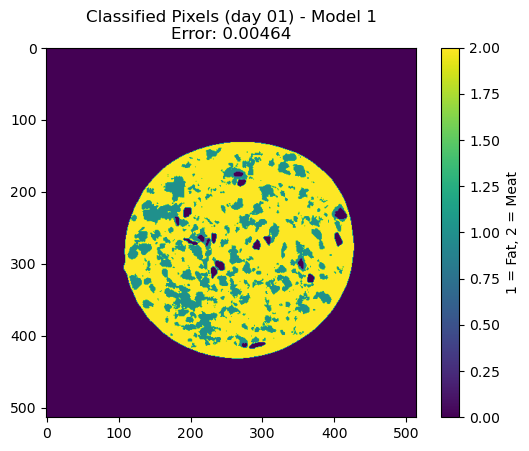

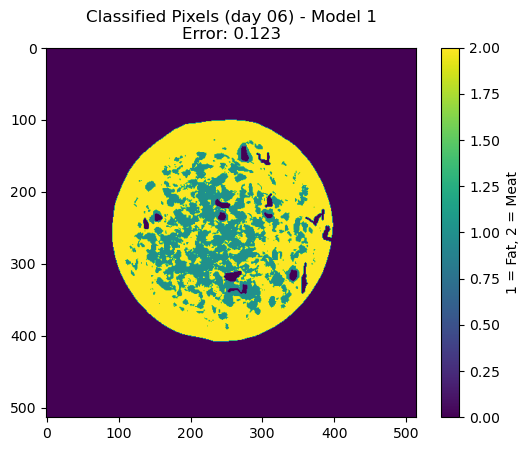

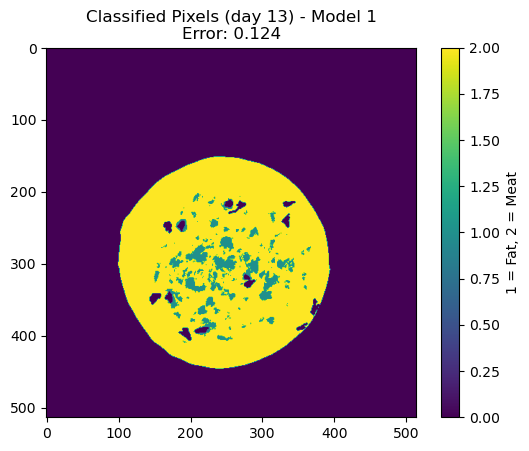

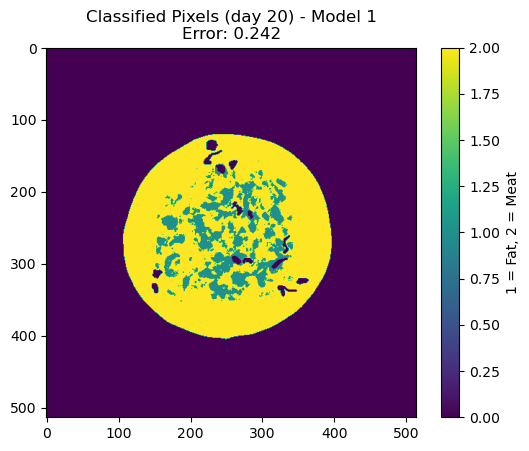

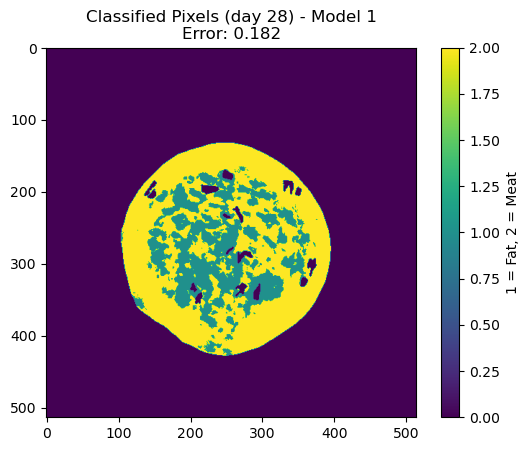

In [24]:
days = ["01", "06", "13", "20", "28"]
errors_model_1 = []

for day in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)

    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

    # Classify data based on Day 1 model (only spectral band 14 taken into account)
    bgPix_14 = bgPix[:, index]
    classified = np.zeros(annotationIm.shape[:2], dtype=np.uint8) # 1 = fat, 2 = meat

    for i in range(bgPix_14.shape[0]):
        r = bgR[i]
        c = bgC[i]

        if bgPix_14[i] > t_list[index]:
            classified[r, c] = 1  # fat
        else:
            classified[r, c] = 2  # meat

    # Estimate error between classified and annotated data
    n_fat = fatPix.shape[0]
    n_meat = meatPix.shape[0]

    fat_errors = np.sum(fatPix[:, index] < t_list[index])
    meat_errors = np.sum(meatPix[:, index] >= t_list[index])

    error = (fat_errors + meat_errors) / (n_fat + n_meat)
    errors_model_1.append(error)

    # Image
    plt.imshow(classified)
    plt.title(f"Classified Pixels (day {day}) - Model 1\nError: {error:.3}")
    plt.colorbar(label="1 = Fat, 2 = Meat")
    plt.show()


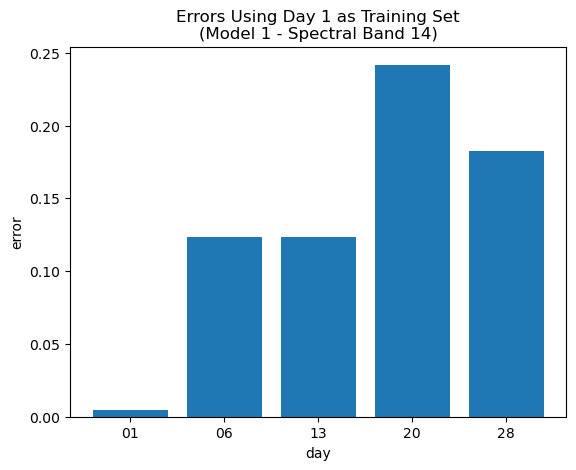

In [25]:
plt.bar(days, errors_model_1)
plt.title(f"Errors Using Day 1 as Training Set\n(Model 1 - Spectral Band 14)")
plt.xlabel("day")
plt.ylabel("error")
plt.show()

#### Model 2 - All Spectral Bands Model

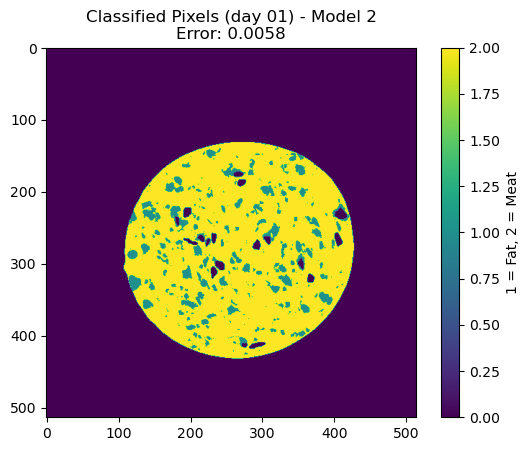

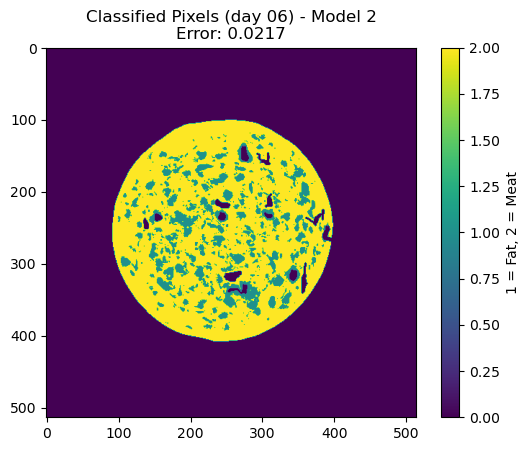

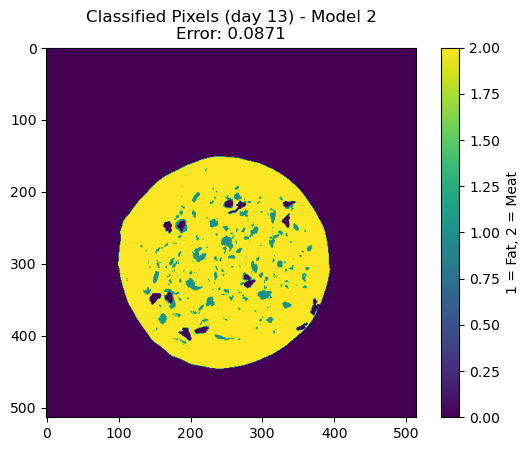

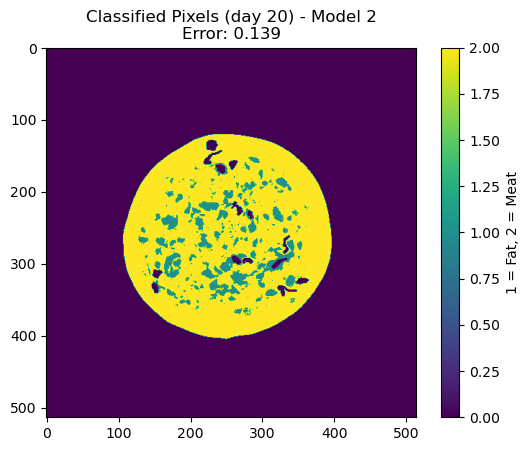

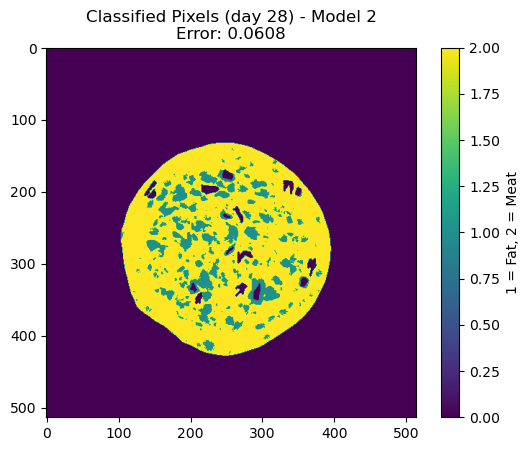

In [26]:
errors_model_2 = []

for day in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)

    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

    # Classify data based on Day 1 model
    classified = np.zeros(annotationIm.shape[:2], dtype=int)
    for i in range(bgPix.shape[0]):
        r = bgR[i]
        c = bgC[i]
        classified[r, c] = Classify(bgPix[i])

    # Estimate error between classified and annotated data
    nf_day = fatPix.shape[0]
    nm_day = meatPix.shape[0]
    fat_errors = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
    meat_errors = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
    error = (fat_errors + meat_errors) / (nf_day + nm_day)
    errors_model_2.append(error)

    # Image
    plt.imshow(classified)
    plt.title(f"Classified Pixels (day {day}) - Model 2\nError: {error:.3}")
    plt.colorbar(label="1 = Fat, 2 = Meat")
    plt.show()

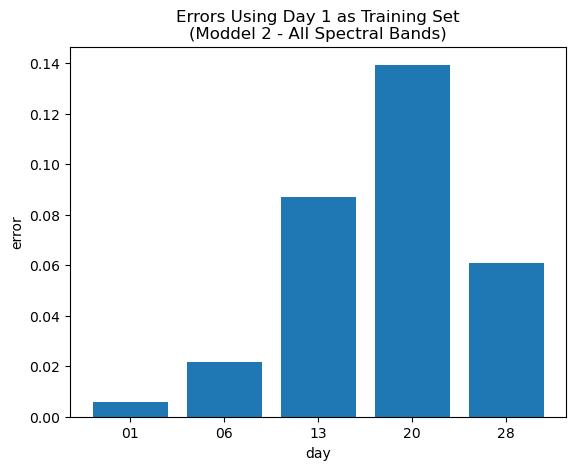

In [27]:
plt.bar(days, errors_model_2)
plt.title(f"Errors Using Day 1 as Training Set\n(Moddel 2 - All Spectral Bands)")
plt.xlabel("day")
plt.ylabel("error")
plt.show()

## 4. Training on each day and error calculated on all the other day

In [ ]:
error_rates = {}
confusion_matrices = {}

for day_training in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day_training}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day_training}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)
    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

    # Model 2
    # Covariance
    cov_fat = np.cov(fatPix, rowvar=False)
    cov_meat = np.cov(meatPix, rowvar=False)

    # Number of fat and meat pixels
    nf = np.shape(fatPix)[0]
    nm = np.shape(meatPix)[0]
    fat_error_count_total = 0
    meat_error_count_total = 0

    # Pooled Covariance - equation 20
    pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

    # Discriminant Function - equation 23
    p_fat = nf / (nf + nm)
    p_meat = nm / (nf + nm)
    cov_inv = np.linalg.inv(pooled_cov)

    def Discriminant(x,i): 
        if i == 1: # if fat 
            return x @ cov_inv @ mean_fat - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
        if i == 2: # if meat 
            return x @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

    def Classify(x):
        S_fat = Discriminant(x, 1)
        S_meat = Discriminant(x, 2)
        if S_fat > S_meat:
            return 1 # fat
        else:
            return 2 # meat
        
    for i in range(bgPix.shape[0]):
        r = bgR[i]
        c = bgC[i]
        classified[r, c] = Classify(bgPix[i])

    errors_model_2 = []
    for day in days:
        if day == day_training:
            continue
        else:
            # Loading data
            matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
            annFile = os.path.join(dirIn, f'annotation_day{day}.png')
            multiIm, annotationIm = hf.loadMulti(matFile, annFile)

            [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
            [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
            [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

            # Classify data based on model 2
            classified = np.zeros(annotationIm.shape[:2], dtype=int)
            for i in range(bgPix.shape[0]):
                r = bgR[i]
                c = bgC[i]
                classified[r, c] = Classify(bgPix[i])

            # Estimate error between classified and annotated data
            nf_day = fatPix.shape[0]
            nm_day = meatPix.shape[0]
            fat_errors = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
            fat_error_count_total += fat_errors
            meat_errors = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
            meat_error_count_total += meat_errors
            error = (fat_errors + meat_errors) / (nf_day + nm_day)
            errors_model_2.append(error)

        error_rates[day_training] = errors_model_2
    confusion_matrix = np.array([[nf-fat_error_count_total, fat_error_count_total,nf], [meat_error_count_total, nm-meat_error_count_total,nm],[nf-fat_error_count_total+meat_error_count_total,nm-meat_error_count_total+fat_error_count_total,nf+nm]])
    confusion_matrices[day_training] = confusion_matrix

print(error_rates)

5
0
0
1
0
0
0
11
1
0
1
1
0
3
1
0
0
0
0
0
{'01': [0.02165543792107796, 0.08708708708708708, 0.13941176470588235, 0.060810810810810814], '06': [0.009855072463768115, 0.0036036036036036037, 0.007647058823529412, 0.006756756756756757], '13': [0.010434782608695653, 0.0014436958614051972, 0.02823529411764706, 0.0111003861003861], '20': [0.01565217391304348, 0.0028873917228103944, 0.003003003003003003, 0.02364864864864865], '28': [0.011594202898550725, 0.0014436958614051972, 0.05525525525525526, 0.10588235294117647]}


## 5. Analysis

Plotting Error for each day using each Training Day

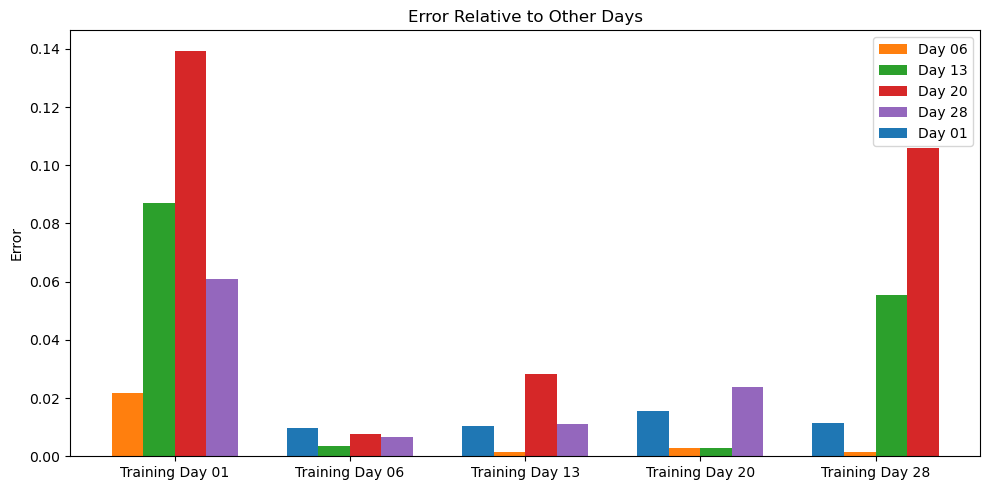

In [55]:
x = np.arange(len(days))
bar_width = 0.18

# fixed color for each comparison day
color_map = {'01': 'C0', '06': 'C1','13': 'C2','20': 'C3','28': 'C4'}

fig, ax = plt.subplots(figsize=(10,5))

legend_added = set()

for i, day in enumerate(days):
    compare_days = [d for d in days if d != day]
    values = error_rates[day]

    n = len(values)
    offsets = np.linspace(-(n-1)/2, (n-1)/2, n) * bar_width

    for off, comp_day, val in zip(offsets, compare_days, values):
        label = f'Day {comp_day}' if comp_day not in legend_added else None

        ax.bar(x[i] + off, val,
               width=bar_width,
               color=color_map[comp_day],
               label=label)

        legend_added.add(comp_day)

ax.set_xticks(x)
ax.set_xticklabels([f'Training Day {d}' for d in days])

ax.set_ylabel("Error")
ax.set_title("Error Relative to Other Days")
ax.legend()

plt.tight_layout()
plt.show()

Plotting Mean Errors

{'01': 0.07724127513121455, '06': 0.006965622911914472, '13': 0.012803539672033503, '20': 0.011297804321876381, '28': 0.04354387673909691}


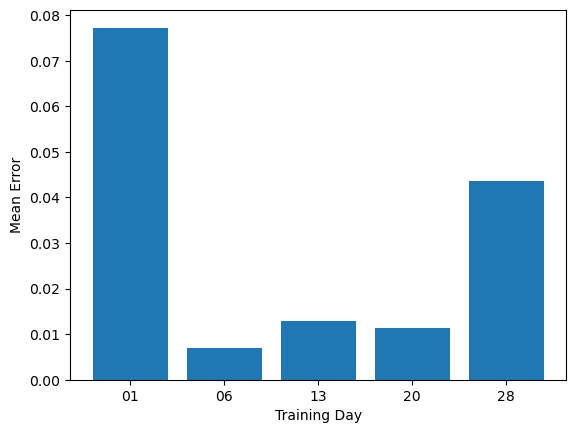

In [56]:
mean_error = {}
for day in error_rates.keys():
    mean_error[day] = np.mean(np.array(error_rates[day]))
print(mean_error)

plt.bar(days, mean_error.values())
plt.xlabel("Training Day")
plt.ylabel("Mean Error")
plt.show()

Evaluation - Classification (Confusion Matrix)

In [57]:
evaluation_metrics = {}
for day in confusion_matrices.keys():
    global_accuracy = (confusion_matrices[day][0,0] + confusion_matrices[day][1,1]) / confusion_matrices[day][2,2]
    global_error_rate = 1-global_accuracy
    class_accuracy_fat = confusion_matrices[day][0,0]/confusion_matrices[day][0,2]
    class_accuracy_meat = confusion_matrices[day][1,1]/confusion_matrices[day][1,2]
    class_error_rate_fat = 1- class_accuracy_fat
    class_error_rate_meat = 1- class_accuracy_meat
    evaluation_metrics[day] = f"Global Accuracy {global_accuracy}\nGlobal Error Rate {global_error_rate}\nClass Accuracy Fat {class_accuracy_fat}\nClass Accuracy Meat {class_accuracy_meat}\nClass Error Rate Fat {class_error_rate_fat}\nClass Error Rate Meat {class_error_rate_meat}"
    print(f"Training Day {day}:\n{evaluation_metrics[day]}\n")






Training Day 01:
Global Accuracy 0.6794202898550724
Global Error Rate 0.3205797101449276
Class Accuracy Fat 0.27645502645502645
Class Accuracy Meat 0.9938080495356038
Class Error Rate Fat 0.7235449735449735
Class Error Rate Meat 0.006191950464396245

Training Day 06:
Global Accuracy 0.9759384023099134
Global Error Rate 0.024061597690086645
Class Accuracy Fat 0.9569060773480663
Class Accuracy Meat 0.9906223358908781
Class Error Rate Fat 0.04309392265193368
Class Error Rate Meat 0.009377664109121886

Training Day 13:
Global Accuracy 0.9447447447447448
Global Error Rate 0.05525525525525521
Class Accuracy Fat 0.8671641791044776
Class Accuracy Meat 0.9969849246231156
Class Error Rate Fat 0.13283582089552237
Class Error Rate Meat 0.0030150753768843908

Training Day 20:
Global Accuracy 0.9488235294117647
Global Error Rate 0.05117647058823527
Class Accuracy Fat 0.8995157384987893
Class Accuracy Meat 0.9954233409610984
Class Error Rate Fat 0.1004842615012107
Class Error Rate Meat 0.004576659038